# **Application SEIR-PINN**


# Table des mati√®res

I. [Contexte et objectifs de l'identification SEIR par PINNs](#i-contexte-et-objectifs-de-lidentification-seir-par-pinns)  
II. [Importation des biblioth√®ques](#ii-importation-des-biblioth√®ques)  
III. [Donn√©es simul√©es par RK4](#iii-donn√©es-simul√©es-par-rk4)  

IV. [Approche conjointe PINN](#iv-approche-conjointe-pinn)  
‚ÄÉIV.1. [Donn√©es compl√®tes ‚Äì Entra√Ænement PINN conjoint](#iv1-donn√©es-compl√®tes--entra√Ænement-pinn-conjoint)  
‚ÄÉIV.2. [Donn√©es partielles ‚Äì Entra√Ænement PINN conjoint](#iv2-donn√©es-partielles--entra√Ænement-pinn-conjoint)  

V. [Approche Split-PINN](#v-approche-split-pinn)  
‚ÄÉV.1. [Donn√©es partielles ‚Äì Entra√Ænement Split-PINN](#v1-donn√©es-partielles--entra√Ænement-split-pinn)  

VI. [Donn√©es r√©elles ‚Äì COVID Maroc](#vi-donn√©es-r√©elles--covid-maroc)  
‚ÄÉVI.1. [Application aux donn√©es r√©elles ‚Äì Entra√Ænement Split-PINN](#vi1-application-aux-donn√©es-r√©elles--entra√Ænement-split-pinn)  

VII. [Bilan et analyse des approches](#vii-bilan-et-analyse-des-approches)


## I. Contexte et objectifs de l'identification SEIR par PINNs

Dans ce notebook, nous appliquons concr√®tement la m√©thode des r√©seaux de neurones inform√©s par la physique (PINNs) au mod√®le √©pid√©mique SEIR.

L‚Äôobjectif est de valider l'efficacit√© des PINNs pour :
- estimer les **param√®tres du mod√®le SEIR** (\(\beta, \sigma, \lambda\)),
- reconstruire les **compartiments dynamiques** \(S(t), E(t), I(t), R(t)\),
- en se basant uniquement sur les **donn√©es simul√©es de la variable infect√©e \(I(t)\)**.

Nous consid√©rons ici une phase de validation num√©rique, en g√©n√©rant des donn√©es synth√©tiques √† partir du sch√©ma de Runge-Kutta (RK4), pour lesquelles les trajectoires exactes sont connues. Cela nous permet d‚Äô√©valuer pr√©cis√©ment la qualit√© des pr√©dictions du r√©seau PINN.

Nous comparerons deux approches :
- une **approche conjointe**, o√π les param√®tres et les √©tats sont estim√©s simultan√©ment,
- une **approche Split-PINN**, qui d√©couple l‚Äôestimation du facteur de sous-d√©tection \(k\) et celle des autres param√®tres.

Les r√©sultats obtenus seront compar√©s aux solutions de r√©f√©rence issues du RK4, afin d‚Äô√©valuer la capacit√© du mod√®le √†  la dynamique r√©elle du syst√®me.

## II. Importation des biblioth√®ques

In [ ]:
#Importation des biblioth√®ques
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.metrics import mean_absolute_error, r2_score
from google.colab import files
import pathlib

## III. Donn√©es simul√©es par RK4


In [ ]:
# -----------------------------------------------------------------
# 0. Param√®tres ¬´ r√©els ¬ª et conditions initiales
# -----------------------------------------------------------------
beta_true, sigma_true, lambda_true = 0.50, 0.33, 0.16
S0, E0, I0, R0                     = 0.96, 0.02, 0.02, 0.00
t0, T_final, dt                    = 0.0, 150.0, 0.1

In [ ]:
def seir_rhs(S, E, I, R):
    dS = -beta_true * S * I
    dE =  beta_true * S * I - sigma_true * E
    dI =  sigma_true * E     - lambda_true * I
    dR =  lambda_true * I
    return dS, dE, dI, dR

t, S, E, I, R = [t0], [S0], [E0], [I0], [R0]
while t[-1] < T_final:
    S_l, E_l, I_l, R_l = S[-1], E[-1], I[-1], R[-1]
    k1 = seir_rhs(S_l,                     E_l,                     I_l,                     R_l)
    k2 = seir_rhs(S_l+dt*k1[0]/2,          E_l+dt*k1[1]/2,          I_l+dt*k1[2]/2,          R_l+dt*k1[3]/2)
    k3 = seir_rhs(S_l+dt*k2[0]/2,          E_l+dt*k2[1]/2,          I_l+dt*k2[2]/2,          R_l+dt*k2[3]/2)
    k4 = seir_rhs(S_l+dt*k3[0],            E_l+dt*k3[1],            I_l+dt*k3[2],            R_l+dt*k3[3])
    S.append(S_l + dt/6*(k1[0]+2*k2[0]+2*k3[0]+k4[0]))
    E.append(E_l + dt/6*(k1[1]+2*k2[1]+2*k3[1]+k4[1]))
    I.append(I_l + dt/6*(k1[2]+2*k2[2]+2*k3[2]+k4[2]))
    R.append(R_l + dt/6*(k1[3]+2*k2[3]+2*k3[3]+k4[3]))
    t.append(t[-1] + dt)


In [ ]:
df = pd.DataFrame({"Temps": t, "S": S, "E": E, "I": I, "R": R})

In [ ]:
print("Aper√ßu des donn√©es simul√©es :")
display(df.head(10))

Aper√ßu des donn√©es simul√©es :


Temps         S         E         I         R
0    0.0  0.960000  0.020000  0.020000  0.000000
1    0.1  0.959032  0.020303  0.020342  0.000323
2    0.2  0.958049  0.020611  0.020689  0.000651
3    0.3  0.957050  0.020925  0.021041  0.000985
4    0.4  0.956035  0.021244  0.021397  0.001324
5    0.5  0.955004  0.021568  0.021758  0.001670
6    0.6  0.953957  0.021898  0.022124  0.002021
7    0.7  0.952894  0.022233  0.022495  0.002378
8    0.8  0.951814  0.022574  0.022872  0.002740
9    0.9  0.950717  0.022920  0.023253  0.003109

In [ ]:
df.to_csv("seir_simulation.csv", index=False)

## IV. Approche conjointe PINN

### IV.1. Donn√©es compl√®tes ‚Äì Entra√Ænement PINN conjoint

In [ ]:
class SEIR_PINN(tf.keras.Model):
    def __init__(self, width=50, depth=3, seed=123):
        super().__init__()
        tf.random.set_seed(seed)

        # r√©seau fully-connected
        layers = [tf.keras.layers.InputLayer((1,))]
        layers += [tf.keras.layers.Dense(width, activation="tanh") for _ in range(depth)]
        layers.append(tf.keras.layers.Dense(4, activation=None))
        self.net = tf.keras.Sequential(layers)

        # param√®tres physiques trainables
        rnd = tf.keras.initializers.RandomUniform(0.1, 0.8)
        self.beta   = self.add_weight(name="beta",   shape=(), initializer=rnd, trainable=True)
        self.sigma  = self.add_weight(name="sigma",  shape=(), initializer=rnd, trainable=True)
        self.lmbda  = self.add_weight(name="lambda", shape=(), initializer=rnd, trainable=True)

    def call(self, t):
        return self.net(t)

In [ ]:
@tf.function
def pinn_loss(model, t, S_obs, E_obs, I_obs, R_obs):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        S_p, E_p, I_p, R_p = tf.split(model(t), 4, axis=1)
        dSdt = tape.gradient(S_p, t)
        dEdt = tape.gradient(E_p, t)
        dIdt = tape.gradient(I_p, t)
        dRdt = tape.gradient(R_p, t)
        #Calcul des r√©sidus des √©quations SEIR
        f1 = dSdt + model.beta  * S_p * I_p
        f2 = dEdt - (model.beta * S_p * I_p - model.sigma * E_p)
        f3 = dIdt - (model.sigma* E_p - model.lmbda * I_p)
        f4 = dRdt - model.lmbda * I_p

    mse_data = tf.reduce_mean((S_p - S_obs)**2 +
                              (E_p - E_obs)**2 +
                              (I_p - I_obs)**2 +
                              (R_p - R_obs)**2)
    mse_phys = tf.reduce_mean(f1**2 + f2**2 + f3**2 + f4**2)
    return mse_data + mse_phys

In [ ]:
# Donn√©es TensorFlow
t_tf = df[["Temps"]].values.astype(np.float32)
S_tf = df[["S"]].values.astype(np.float32)
E_tf = df[["E"]].values.astype(np.float32)
I_tf = df[["I"]].values.astype(np.float32)
R_tf = df[["R"]].values.astype(np.float32)

In [ ]:
model = SEIR_PINN()
opt   = tf.keras.optimizers.Adam(1e-3)

EPOCHS = 5000

In [ ]:
hist_b, hist_s, hist_l = [], [], []

for k in range(EPOCHS + 1):
    with tf.GradientTape() as tape:
        L = pinn_loss(model, t_tf, S_tf, E_tf, I_tf, R_tf)
    grads = tape.gradient(L, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))

    hist_b.append(model.beta.numpy())
    hist_s.append(model.sigma.numpy())
    hist_l.append(model.lmbda.numpy())

    if k % 500 == 0:
        print(f"[{k:4d}] loss={L.numpy():.3e}  Œ≤={hist_b[-1]:.4f}  œÉ={hist_s[-1]:.4f}  Œª={hist_l[-1]:.4f}")

print("\nEstimation finale  Œ≤={:.5f}  œÉ={:.5f}  Œª={:.5f}"
      .format(model.beta.numpy(), model.sigma.numpy(), model.lmbda.numpy()))


[   0] loss=1.123e+00  Œ≤=0.1233  œÉ=0.1213  Œª=0.1213
[ 500] loss=6.146e-04  Œ≤=0.3133  œÉ=0.1374  Œª=0.1140
[1000] loss=2.614e-04  Œ≤=0.3819  œÉ=0.1961  Œª=0.1268
[1500] loss=1.451e-04  Œ≤=0.4277  œÉ=0.2488  Œª=0.1417
[2000] loss=7.656e-05  Œ≤=0.4572  œÉ=0.2839  Œª=0.1499
[2500] loss=1.556e-04  Œ≤=0.4769  œÉ=0.3014  Œª=0.1556
[3000] loss=2.977e-05  Œ≤=0.4817  œÉ=0.3117  Œª=0.1562
[3500] loss=2.386e-05  Œ≤=0.4881  œÉ=0.3185  Œª=0.1576
[4000] loss=1.928e-05  Œ≤=0.4886  œÉ=0.3192  Œª=0.1578
[4500] loss=2.458e-05  Œ≤=0.4793  œÉ=0.3071  Œª=0.1549
[5000] loss=1.787e-05  Œ≤=0.4960  œÉ=0.3282  Œª=0.1598

Estimation finale  Œ≤=0.49596  œÉ=0.32818  Œª=0.15980


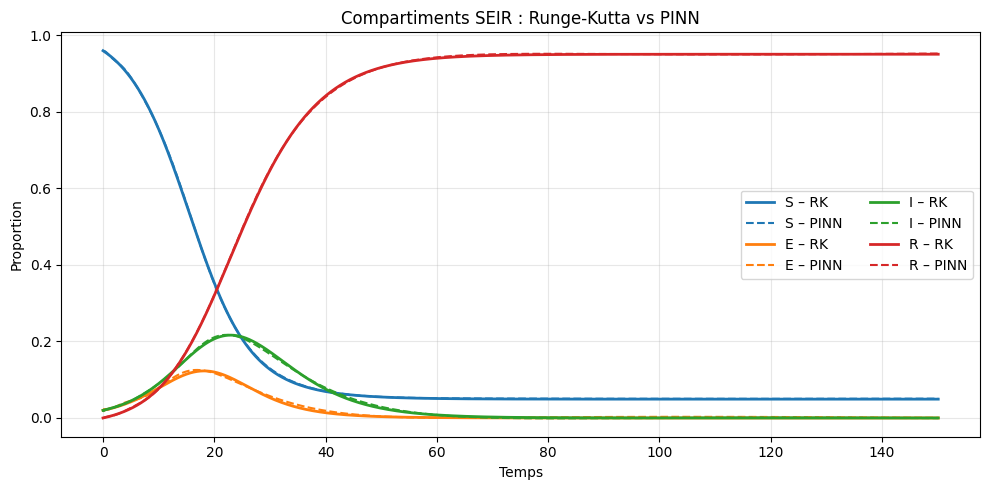

In [ ]:
# -----------------------------------------------------------------
# 3. Visualisation des compartiments
# -----------------------------------------------------------------
S_pred, E_pred, I_pred, R_pred = tf.split(model(t_tf), 4, axis=1)
cS, cE, cI, cR = "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"

plt.figure(figsize=(10,5))
plt.plot(t, S, cS, lw=2, label="S ‚Äì RK"); plt.plot(t, S_pred, cS, ls="--", lw=1.5, label="S ‚Äì PINN")
plt.plot(t, E, cE, lw=2, label="E ‚Äì RK"); plt.plot(t, E_pred, cE, ls="--", lw=1.5, label="E ‚Äì PINN")
plt.plot(t, I, cI, lw=2, label="I ‚Äì RK"); plt.plot(t, I_pred, cI, ls="--", lw=1.5, label="I ‚Äì PINN")
plt.plot(t, R, cR, lw=2, label="R ‚Äì RK"); plt.plot(t, R_pred, cR, ls="--", lw=1.5, label="R ‚Äì PINN")
plt.title("Compartiments SEIR : Runge-Kutta vs PINN")
plt.xlabel("Temps"); plt.ylabel("Proportion"); plt.grid(alpha=0.3)
plt.legend(ncol=2); plt.tight_layout(); plt.show()


In [ ]:
# --------------------------------------------
# Style graphique
# --------------------------------------------
sns.set_theme(style="white", context="talk", palette="colorblind")

plt.rcParams["figure.facecolor"] = "#f2f2f2"
plt.rcParams["axes.facecolor"]   = "#f2f2f2"
plt.rcParams["axes.edgecolor"]   = "lightgray"
plt.rcParams["axes.linewidth"]   = 1.0
plt.rc("font",   family="serif", weight="light")
plt.rc("axes",   titlesize=13, labelsize=11)
plt.rc("legend", fontsize=9, handlelength=1, handletextpad=0.5, borderpad=0.4)
plt.rc("xtick",  labelsize=10)
plt.rc("ytick",  labelsize=10)

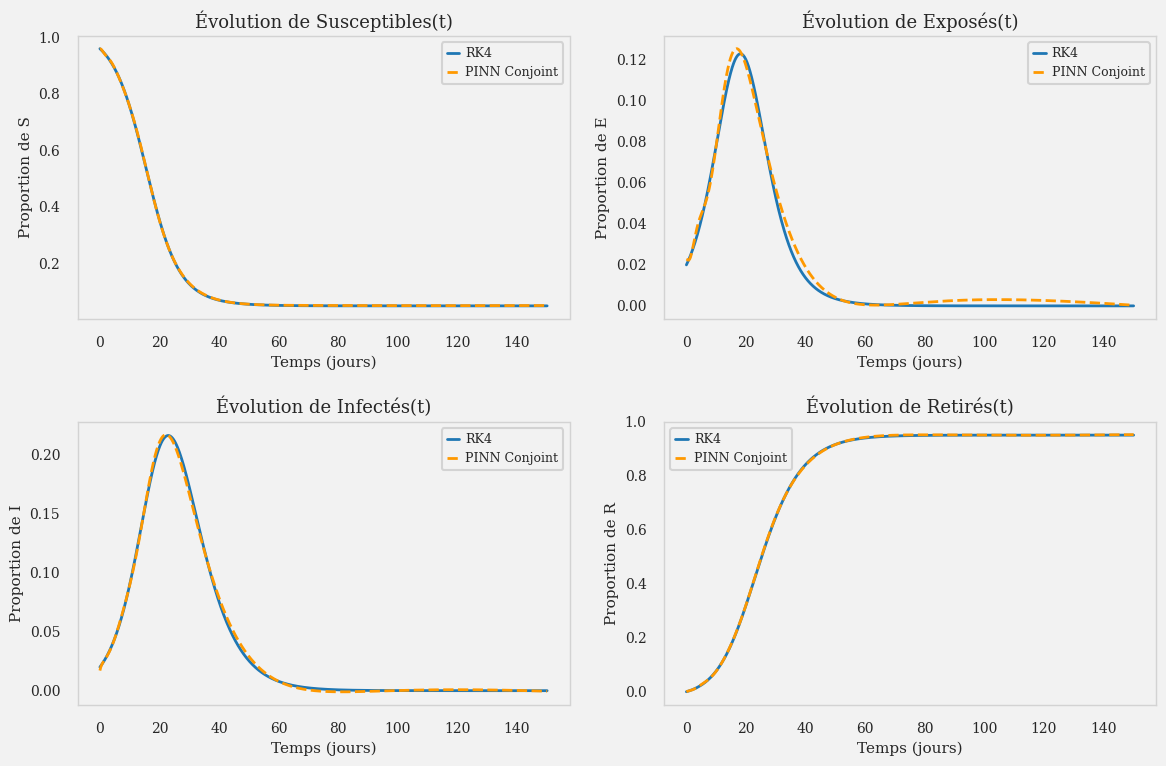

In [ ]:
# --------------------------------------------
# Pr√©dictions PINN (conjointes)
# --------------------------------------------
S_pred, E_pred, I_pred, R_pred = tf.split(model(t_tf), 4, axis=1)

# --------------------------------------------
# Cr√©ation des sous-figures (2x2)
# --------------------------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Couleurs
rk4_color = "#1f77b4"  # bleu
pinn_color = "#ff9900"  # orange fonc√©

#  S(t)
axs[0, 0].plot(t, S,      color=rk4_color, lw=2, label="RK4")
axs[0, 0].plot(t, S_pred, color=pinn_color, lw=2, ls="--", label="PINN Conjoint")
axs[0, 0].set_title("√âvolution de Susceptibles(t)")
axs[0, 0].set_ylabel("Proportion de S")
axs[0, 0].set_xlabel("Temps (jours)")
axs[0, 0].legend()
axs[0, 0].grid(False)

#  E(t)
axs[0, 1].plot(t, E,      color=rk4_color, lw=2, label="RK4")
axs[0, 1].plot(t, E_pred, color=pinn_color, lw=2, ls="--", label="PINN Conjoint")
axs[0, 1].set_title("√âvolution de Expos√©s(t)")
axs[0, 1].set_ylabel("Proportion de E")
axs[0, 1].set_xlabel("Temps (jours)")
axs[0, 1].legend()
axs[0, 1].grid(False)

# I(t)
axs[1, 0].plot(t, I,      color=rk4_color, lw=2, label="RK4")
axs[1, 0].plot(t, I_pred, color=pinn_color, lw=2, ls="--", label="PINN Conjoint")
axs[1, 0].set_title("√âvolution de Infect√©s(t)")
axs[1, 0].set_ylabel("Proportion de I")
axs[1, 0].set_xlabel("Temps (jours)")
axs[1, 0].legend()
axs[1, 0].grid(False)

#  R(t)
axs[1, 1].plot(t, R,      color=rk4_color, lw=2, label="RK4")
axs[1, 1].plot(t, R_pred, color=pinn_color, lw=2, ls="--", label="PINN Conjoint")
axs[1, 1].set_title("√âvolution de Retir√©s(t)")
axs[1, 1].set_ylabel("Proportion de R")
axs[1, 1].set_xlabel("Temps (jours)")
axs[1, 1].legend()
axs[1, 1].grid(False)

plt.tight_layout()
# ‚úÖ Sauvegarde de la figure
plt.savefig("comparaison_SEIR_PINN_vs_RK4.pdf", format="pdf", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

In [256]:
from google.colab import files
files.download("comparaison_SEIR_PINN_vs_RK4.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### IV.2. Donn√©es partielles ‚Äì Entra√Ænement PINN conjoint


In [ ]:
# --------------------------------------------
# Importations et configuration du style
# --------------------------------------------
sns.set_theme(
    style="white",        # fond uni
    context="talk",       # textes plus lisibles
    palette="colorblind"  # palette accessible
)

# Fond gris clair pour figure et axes
plt.rcParams["figure.facecolor"] = "#f2f2f2"
plt.rcParams["axes.facecolor"]   = "#f2f2f2"
plt.rcParams["axes.edgecolor"]   = "lightgray"
plt.rcParams["axes.linewidth"]   = 1.0

# Tailles et styles de police
plt.rc("font",   family="serif", weight="light")
plt.rc("axes",   titlesize=12, labelsize=12)
plt.rc("legend", fontsize=9, handlelength=0.8, handletextpad=0.3, borderpad=0.3)
plt.rc("xtick",  labelsize=10)
plt.rc("ytick",  labelsize=10)


In [ ]:
df = pd.read_csv("seir_simulation.csv")
# Pour l'entra√Ænement, on ne conserve que Temps et I
t_list = df["Temps"].tolist()
I_list = df["I"].tolist()
# Tensores pour TensorFlow
t_tf = df[["Temps"]].values.astype(np.float32)
I_tf = df[["I"]    ].values.astype(np.float32)

In [ ]:
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# 1. Conjoint-PINN
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
class SEIR_Conjoint_PINN(tf.keras.Model):
    def __init__(self, width=50, depth=3, seed=123):
        super().__init__()
        tf.random.set_seed(seed)
        layers = [tf.keras.layers.InputLayer((1,))]
        for _ in range(depth):
            layers.append(tf.keras.layers.Dense(width, activation="tanh"))
        layers.append(tf.keras.layers.Dense(4, activation=None))
        self.net = tf.keras.Sequential(layers)
        rnd = tf.keras.initializers.RandomUniform(0.1, 0.8)
        self.beta  = self.add_weight(shape=(), initializer=rnd,
                                     trainable=True, name="beta")
        self.sigma = self.add_weight(shape=(), initializer=rnd,
                                     trainable=True, name="sigma")
        self.lmbda = self.add_weight(shape=(), initializer=rnd,
                                     trainable=True, name="lambda")

    def call(self, t):
        return self.net(t)
@tf.function
def pinn_loss_conjoint(model, t, I_obs):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        S_p, E_p, I_p, R_p = tf.split(model(t), 4, axis=1)
        dS = tape.gradient(S_p, t)
        dE = tape.gradient(E_p, t)
        dI = tape.gradient(I_p, t)
        dR = tape.gradient(R_p, t)
        f1 = dS + model.beta * S_p * I_p
        f2 = dE - (model.beta * S_p * I_p - model.sigma * E_p)
        f3 = dI - (model.sigma * E_p - model.lmbda * I_p)
        f4 = dR - model.lmbda * I_p
    mse_data = tf.reduce_mean((I_p - I_obs)**2)
    mse_phys = tf.reduce_mean(f1**2 + f2**2 + f3**2 + f4**2)
    return mse_data + mse_phys, mse_data

modelC = SEIR_Conjoint_PINN()
optC   = tf.keras.optimizers.Adam(1e-3)
EPOCHS = 5000

In [ ]:
print("‚îÄ‚îÄ‚îÄ Entra√Ænement Conjoint-PINN ‚îÄ‚îÄ‚îÄ")
for k in range(EPOCHS + 1):
    with tf.GradientTape() as tape:
        lossC, dataC = pinn_loss_conjoint(modelC, t_tf, I_tf)
    grads = tape.gradient(lossC, modelC.trainable_variables)
    optC.apply_gradients(zip(grads, modelC.trainable_variables))
    if k % 500 == 0:
        print(f"[Conjoint {k:4d}] total_loss={lossC.numpy():.3e} "
              f"data_loss={dataC.numpy():.3e} "
              f"Œ≤={modelC.beta.numpy():.4f} "
              f"œÉ={modelC.sigma.numpy():.4f} "
              f"Œª={modelC.lmbda.numpy():.4f}")

# pr√©diction Conjoint
I_pred_C = tf.split(modelC(t_tf), 4, axis=1)[2].numpy().squeeze()


‚îÄ‚îÄ‚îÄ Entra√Ænement Conjoint-PINN ‚îÄ‚îÄ‚îÄ
[Conjoint    0] total_loss=7.778e-01 data_loss=3.432e-01 Œ≤=0.4560 œÉ=0.4560 Œª=0.4560
[Conjoint  500] total_loss=6.299e-04 data_loss=3.079e-04 Œ≤=0.4454 œÉ=0.4373 Œª=0.4201
[Conjoint 1000] total_loss=2.749e-04 data_loss=1.057e-04 Œ≤=0.4483 œÉ=0.4387 Œª=0.3920
[Conjoint 1500] total_loss=1.227e-04 data_loss=4.873e-05 Œ≤=0.4513 œÉ=0.4398 Œª=0.3671
[Conjoint 2000] total_loss=5.148e-05 data_loss=2.076e-05 Œ≤=0.4502 œÉ=0.4399 Œª=0.3495
[Conjoint 2500] total_loss=2.824e-05 data_loss=9.821e-06 Œ≤=0.4437 œÉ=0.4388 Œª=0.3383
[Conjoint 3000] total_loss=5.339e-05 data_loss=3.508e-05 Œ≤=0.4338 œÉ=0.4357 Œª=0.3243
[Conjoint 3500] total_loss=1.535e-05 data_loss=5.805e-06 Œ≤=0.4223 œÉ=0.4318 Œª=0.3110
[Conjoint 4000] total_loss=1.127e-05 data_loss=4.464e-06 Œ≤=0.4099 œÉ=0.4279 Œª=0.2977
[Conjoint 4500] total_loss=4.700e-04 data_loss=3.660e-04 Œ≤=0.3967 œÉ=0.4237 Œª=0.2814
[Conjoint 5000] total_loss=7.106e-06 data_loss=3.879e-06 Œ≤=0.3857 œÉ=0.4184 Œª=0.

In [ ]:
df = pd.DataFrame({
    "Temps": t,
    "S":     S,
     "E":     E,
    "I":     I,
    "R":     R
})
t_list = t
S_list = S
E_list = E
I_list = I
R_list = R

In [ ]:
# --------------------------------------------
# Extraction des trajectoires PINNs
# --------------------------------------------
outsC = modelC(t_tf)
S_C, E_C, I_C, R_C = [x.numpy().squeeze()
                     for x in tf.split(outsC,4,axis=1)]

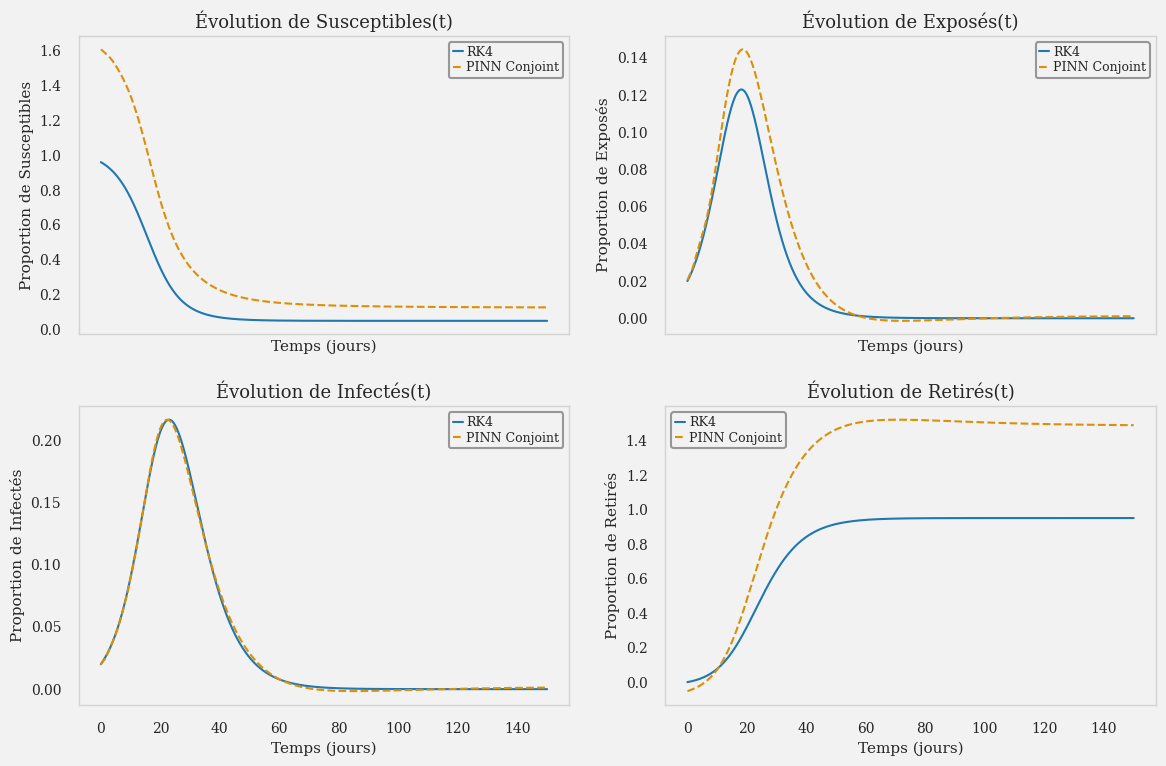

In [257]:
# --------------------------------------------
#Figure RK4 vs PINN Conjoint
# --------------------------------------------
fig, axs = plt.subplots(2,2,figsize=(12,8), sharex=True)
labels    = ["Susceptibles","Expos√©s","Infect√©s","Retir√©s"]
rk4_vals  = [S_list, E_list, I_list, R_list]
conj_vals = [S_C,    E_C,    I_C,    R_C]

for ax, lab, rk4, cj in zip(axs.ravel(), labels, rk4_vals, conj_vals):
    ax.plot(t_list, rk4,
            color="#1f77b4", linestyle="-", linewidth=1.5, label="RK4")
    ax.plot(t_list, cj,
            color="C1", linestyle="--", linewidth=1.5, label="PINN Conjoint")
    ax.set_title(f"√âvolution de {lab}(t)", pad=6)
    ax.set_xlabel("Temps (jours)")
    ax.set_ylabel(f"Proportion de {lab}")
    ax.set_facecolor("#f2f2f2")
    ax.grid(False)
    leg = ax.legend(loc="best", frameon=True,
                    fontsize=9, handlelength=0.8,
                    handletextpad=0.3, borderpad=0.3,
                    labelspacing=0.2)
    leg.get_frame().set_facecolor("none")
    leg.get_frame().set_edgecolor("gray")


plt.tight_layout()
# ‚úÖ Sauvegarde de la figure
plt.savefig("comparaison_SEIR_PINN_vs_RK4_conjoint.pdf", format="pdf", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

In [258]:
from google.colab import files
files.download("comparaison_SEIR_PINN_vs_RK4_conjoint.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## V. Approche Split-PINN

### V.1. Donn√©es partielles ‚Äì Entra√Ænement Split-PINN

In [178]:
# =========================================================
# Phase A : Apprentissage de l‚Äôinfect√© IÃÇ(t)
# =========================================================
tf.keras.backend.set_floatx("float32"); tf.random.set_seed(123)

# 1) Donn√©es (t, I)
df   = pd.read_csv("seir_simulation.csv")           # colonnes ¬´ Temps ¬ª, ¬´ I ¬ª
t_tf = df[["Temps"]].values.astype("float32")
I_tf = df[["I"    ]].values.astype("float32")

# 2) R√©seau  ‚ü∂  IÃÇ(t)
class PINN_I(tf.keras.Model):
    def __init__(self, width=50, depth=3, seed=123):
        super().__init__()
        tf.random.set_seed(seed)
        layers = [tf.keras.layers.InputLayer((1,))]
        for _ in range(depth):
            layers.append(tf.keras.layers.Dense(width, activation="tanh"))
        layers.append(tf.keras.layers.Dense(1))     # sortie lin√©aire
        self.net = tf.keras.Sequential(layers)

    def call(self, t):
        return tf.nn.softplus(self.net(t))          # IÃÇ ‚â• 0

modelA = PINN_I()
optA   = tf.keras.optimizers.Adam(1e-3)
EPOCHS = 4000

print("‚îÄ‚îÄ‚îÄ Phase A : entra√Ænement (MSE_I) ‚îÄ‚îÄ‚îÄ")
for k in range(EPOCHS + 1):
    with tf.GradientTape() as tape:
        I_hat = modelA(t_tf)
        loss  = tf.reduce_mean((I_hat - I_tf)**2)   # L_I (ligne 4 de l‚Äôalgorithme)
    optA.apply_gradients(zip(tape.gradient(loss, modelA.trainable_variables),
                             modelA.trainable_variables))
    if k % 500 == 0:
        print(f"[A {k:4d}] MSE_I = {loss.numpy():.3e}")

# 3) IÃÇ(t) sera r√©-utilis√©
modelA.trainable = False


‚îÄ‚îÄ‚îÄ Phase A : entra√Ænement (MSE_I) ‚îÄ‚îÄ‚îÄ
[A    0] MSE_I = 4.061e-01
[A  500] MSE_I = 7.268e-04
[A 1000] MSE_I = 4.537e-05
[A 1500] MSE_I = 1.636e-05
[A 2000] MSE_I = 8.332e-06
[A 2500] MSE_I = 5.194e-06
[A 3000] MSE_I = 3.685e-06
[A 3500] MSE_I = 2.780e-06
[A 4000] MSE_I = 2.159e-06


In [188]:
# =========================================================
# Phase B : Apprentissage de S(t), E(t), R(t), Œ≤, œÉ, Œ≥
# =========================================================

class PINN_SER(tf.keras.Model):
    def __init__(self, width=50, depth=3, seed=123):
        super().__init__()
        tf.random.set_seed(seed)
        layers = [tf.keras.layers.InputLayer((1,))]
        for _ in range(depth):
            layers.append(tf.keras.layers.Dense(width, activation="tanh"))
        layers.append(tf.keras.layers.Dense(3))  # S, E, R
        self.net = tf.keras.Sequential(layers)
        # param√®tres dynamiques √† estimer
        rnd = tf.keras.initializers.RandomUniform(0.1, 0.8)
        self.beta  = self.add_weight(shape=(), initializer=rnd, trainable=True, name="beta")
        self.sigma = self.add_weight(shape=(), initializer=rnd, trainable=True, name="sigma")
        self.gamma = self.add_weight(shape=(), initializer=rnd, trainable=True, name="gamma")

    def call(self, t):
        return tf.nn.sigmoid(self.net(t))  # born√© entre [0,1]

@tf.function
def loss_phaseB(model, t, I_obs, lambda_data=1.0):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)

        # 1. Sorties du r√©seau B
        S, E, R = tf.split(model(t), 3, axis=1)

        # 2. I_hat = output de modelA, d√©pend de t
        I_hat = modelA(t)

        # 3. D√©riv√©es temporelles
        dS = tape.gradient(S, t)
        dE = tape.gradient(E, t)
        dR = tape.gradient(R, t)
        dI = tape.gradient(I_hat, t)

        # 4. R√©sidus SEIR
        fS = dS + model.beta * S * I_hat
        fE = dE - model.beta * S * I_hat + model.sigma * E
        fI = dI - model.sigma * E + model.gamma * I_hat
        fR = dR - model.gamma * I_hat

    # 5. Pertes
    mse_S = tf.reduce_mean(fS**2)
    mse_E = tf.reduce_mean(fE**2)
    mse_I = tf.reduce_mean(fI**2)
    mse_R = tf.reduce_mean(fR**2)
    mse_data = tf.reduce_mean((I_hat - I_obs)**2)  # renfort

    loss_tot = mse_S + mse_E + mse_I + mse_R + lambda_data * mse_data
    return loss_tot, (mse_S, mse_E, mse_I, mse_R, mse_data)

# ‚îÄ‚îÄ‚îÄ Initialisation du mod√®le et optimiseur ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
modelB = PINN_SER()
optB   = tf.keras.optimizers.Adam(1e-3)
EPOCHS_B = 5000

# modelA doit √™tre d√©j√† entra√Æn√© en Phase A (et non re-entra√Æn√© ici)
modelA.trainable = False


In [189]:
print("‚îÄ‚îÄ‚îÄ Phase B : entra√Ænement Split-PINN ‚îÄ‚îÄ‚îÄ")
for k in range(EPOCHS_B + 1):
    with tf.GradientTape() as tape:
        Ltot, (LS, LE, LI, LR, Ldata) = loss_phaseB(modelB, t_tf, I_tf, lambda_data=1.0)
    grads = tape.gradient(Ltot, modelB.trainable_variables)
    optB.apply_gradients(zip(grads, modelB.trainable_variables))

    if k % 500 == 0:
        print(f"[B {k:4d}] Ltot={Ltot.numpy():.3e}  "
              f"MSE_I={Ldata.numpy():.3e}  "
              f"Œ≤={modelB.beta.numpy():.4f}  "
              f"œÉ={modelB.sigma.numpy():.4f}  "
              f"Œ≥={modelB.gamma.numpy():.4f}")


‚îÄ‚îÄ‚îÄ Phase B : entra√Ænement Split-PINN ‚îÄ‚îÄ‚îÄ
[B    0] Ltot=7.521e-02  MSE_I=2.158e-06  Œ≤=0.3252  œÉ=0.3232  Œ≥=0.3252
[B  500] Ltot=5.106e-05  MSE_I=2.158e-06  Œ≤=0.2788  œÉ=0.3111  Œ≥=0.0873
[B 1000] Ltot=2.404e-05  MSE_I=2.158e-06  Œ≤=0.2769  œÉ=0.3104  Œ≥=0.0493
[B 1500] Ltot=1.877e-05  MSE_I=2.158e-06  Œ≤=0.2861  œÉ=0.3103  Œ≥=0.0427
[B 2000] Ltot=1.547e-05  MSE_I=2.158e-06  Œ≤=0.3114  œÉ=0.3105  Œ≥=0.0515
[B 2500] Ltot=1.161e-05  MSE_I=2.158e-06  Œ≤=0.3636  œÉ=0.3114  Œ≥=0.0705
[B 3000] Ltot=6.755e-06  MSE_I=2.158e-06  Œ≤=0.4427  œÉ=0.3128  Œ≥=0.1009
[B 3500] Ltot=3.996e-06  MSE_I=2.158e-06  Œ≤=0.5112  œÉ=0.3138  Œ≥=0.1265
[B 4000] Ltot=3.357e-06  MSE_I=2.158e-06  Œ≤=0.5456  œÉ=0.3143  Œ≥=0.1365
[B 4500] Ltot=3.183e-06  MSE_I=2.158e-06  Œ≤=0.5584  œÉ=0.3144  Œ≥=0.1393
[B 5000] Ltot=3.100e-06  MSE_I=2.158e-06  Œ≤=0.5625  œÉ=0.3145  Œ≥=0.1401


In [190]:
outsB = modelB(t_tf)  # shape = (N, 3)
S_B, E_B, R_B = [x.numpy().squeeze() for x in tf.split(outsB, 3, axis=1)]

I_B = modelA(t_tf).numpy().squeeze()  # I(t) venant de la Phase A


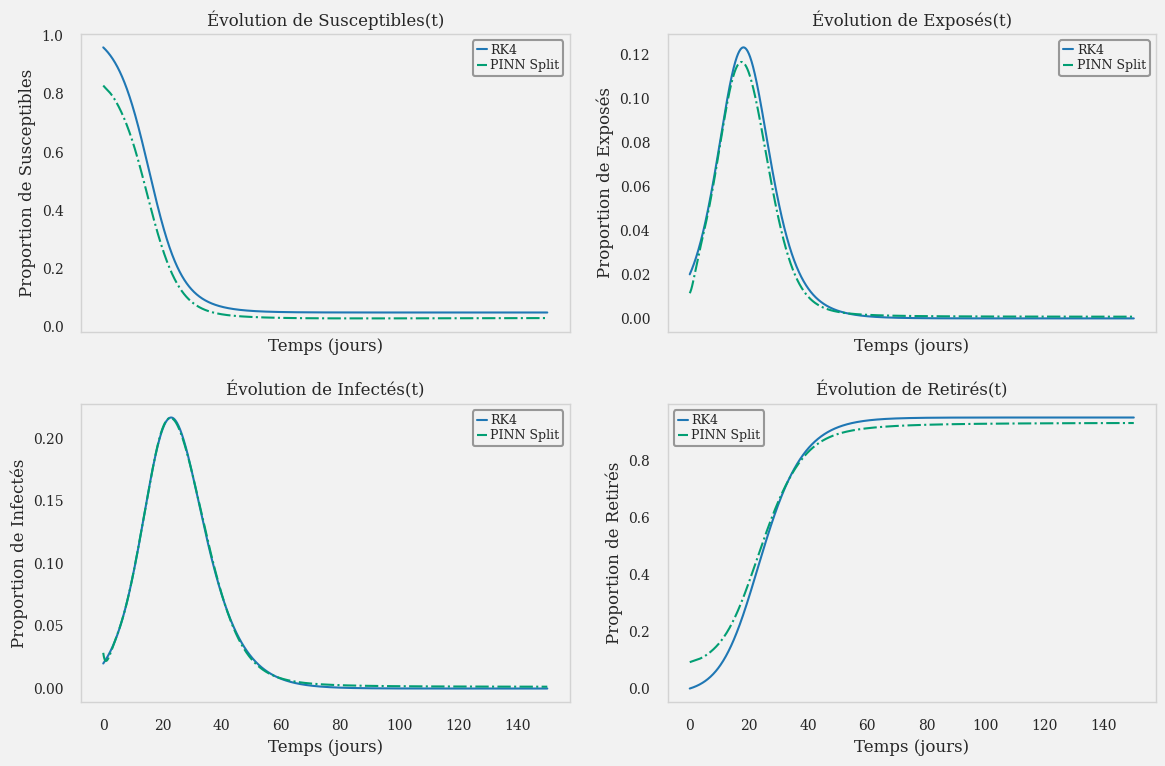

In [191]:
# --------------------------------------------
# BLOC 3B : Figure RK4 vs PINN Split
# --------------------------------------------
fig, axs = plt.subplots(2,2,figsize=(12,8), sharex=True)
split_vals = [S_B, E_B, I_B, R_B]

for ax, lab, rk4, sp in zip(axs.ravel(), labels, rk4_vals, split_vals):
    ax.plot(t_list, rk4,
            color="#1f77b4", linestyle="-", linewidth=1.5, label="RK4")
    ax.plot(t_list, sp,
            color="C2", linestyle="-.", linewidth=1.5, label="PINN Split")
    ax.set_title(f"√âvolution de {lab}(t)", pad=6)
    ax.set_xlabel("Temps (jours)")
    ax.set_ylabel(f"Proportion de {lab}")
    ax.set_facecolor("#f2f2f2")
    ax.grid(False)
    leg = ax.legend(loc="best", frameon=True,
                    fontsize=9, handlelength=0.8,
                    handletextpad=0.3, borderpad=0.3,
                    labelspacing=0.2)
    leg.get_frame().set_facecolor("none")
    leg.get_frame().set_edgecolor("gray")


plt.tight_layout()
# ‚úÖ Sauvegarde de la figure
plt.savefig("comparaison_SEIR_PINN_vs_RK4_splita.pdf", format="pdf", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

In [259]:
from google.colab import files
files.download("comparaison_SEIR_PINN_vs_RK4_splita.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

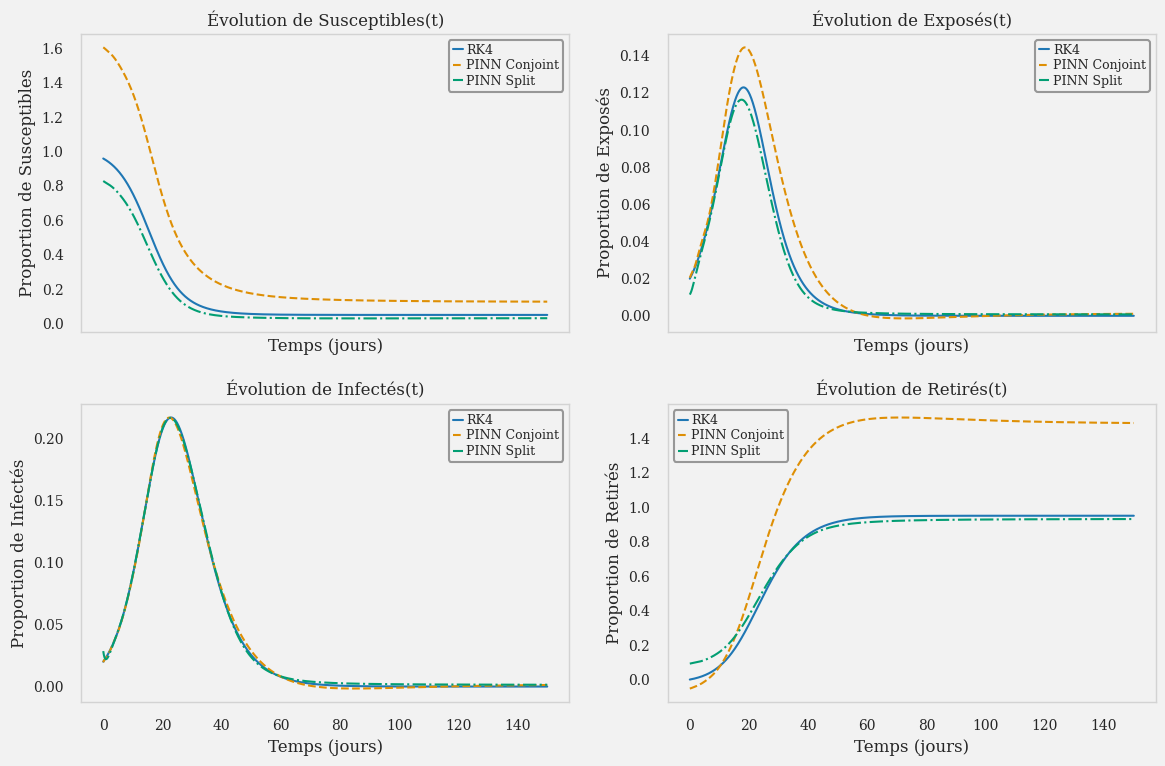

In [193]:
# --------------------------------------------
# BLOC 2 : Extraction des courbes simul√©es
# (Suppose que t_list, S_list, E_list, I_list, R_list
#  et t_tf, modelC, modelB, modelA sont d√©j√† d√©finis)
# --------------------------------------------

# RK4 (v√©rit√©s simul√©es)
rk4_vals  = [S_list, E_list, I_list, R_list]

# Conjoint : pr√©dictions 4 sorties
outsC = modelC(t_tf)
S_C, E_C, I_C, R_C = [x.numpy().squeeze() for x in tf.split(outsC, 4, axis=1)]
conj_vals = [S_C, E_C, I_C, R_C]

# Split : S, E, R du modelB + I du modelA
outsB = modelB(t_tf)
S_B, E_B, R_B = [x.numpy().squeeze() for x in tf.split(outsB, 3, axis=1)]
I_B = modelA(t_tf).numpy().squeeze()
split_vals = [S_B, E_B, I_B, R_B]

# --------------------------------------------
# BLOC 3 : Trac√© comparatif 2√ó2
# --------------------------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

labels = ["Susceptibles", "Expos√©s", "Infect√©s", "Retir√©s"]

for ax, lab, rk4, cj, sp in zip(axs.ravel(), labels, rk4_vals, conj_vals, split_vals):
    # RK4 : bleu
    ax.plot(t_list, rk4, color="#1f77b4", linestyle="-", linewidth=1.5, label="RK4")
    # Conjoint : orange pointill√©
    ax.plot(t_list, cj, color="C1", linestyle="--", linewidth=1.5, label="PINN Conjoint")
    # Split : vert tiret√©
    ax.plot(t_list, sp, color="C2", linestyle="-.", linewidth=1.5, label="PINN Split")

    ax.set_title(f"√âvolution de {lab}(t)", pad=6)
    ax.set_xlabel("Temps (jours)")
    ax.set_ylabel(f"Proportion de {lab}")
    ax.set_facecolor("#f2f2f2")
    ax.grid(False)

    leg = ax.legend(loc="best", frameon=True,
                    fontsize=9, handlelength=0.8,
                    handletextpad=0.3, borderpad=0.3,
                    labelspacing=0.2)
    leg.get_frame().set_facecolor("none")
    leg.get_frame().set_edgecolor("gray")


plt.tight_layout()
# ‚úÖ Sauvegarde de la figure
plt.savefig("comparaison_SEIR_PINN_vs_RK4_deux.pdf", format="pdf", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

In [260]:
from google.colab import files
files.download("comparaison_SEIR_PINN_vs_RK4_deux.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [195]:
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# Bloc 4 ter ‚Äì Tableau des √©carts RK4 vs PINNs (Split + Conjoint)
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# 1) Pr√©dictions Conjoint-PINN (sorties : S, E, I, R)
outsC = modelC(t_tf)
S_C, E_C, I_C, R_C = (x.numpy().squeeze() for x in tf.split(outsC, 4, axis=1))

# 2) Pr√©dictions Split-PINN (sorties : S, E, R)
outsB = modelB(t_tf)
S_B, E_B, R_B = (x.numpy().squeeze() for x in tf.split(outsB, 3, axis=1))
I_B = modelA(t_tf).numpy().squeeze()  # I(t) s√©par√©

# 3) Construire le DataFrame g√©n√©ral (RK4, Conjoint, Split)
df_table = pd.DataFrame({
    "Temps":       df["Temps"].values,
    # RK4 (v√©rit√© terrain)
    "S_RK4":       df["S"].values,
    "E_RK4":       df["E"].values,
    "I_RK4":       df["I"].values,
    "R_RK4":       df["R"].values,
    # Conjoint-PINN
    "S_Conjoint":  S_C,
    "E_Conjoint":  E_C,
    "I_Conjoint":  I_C,
    "R_Conjoint":  R_C,
    # Split-PINN
    "S_Split":     S_B,
    "E_Split":     E_B,
    "I_Split":     I_B,
    "R_Split":     R_B,
})

# 4) Calcul des √©carts (PINN - RK4) pour chaque m√©thode
for comp in ["S", "E", "I", "R"]:
    df_table[f"{comp}_Œî_Conjoint"] = df_table[f"{comp}_Conjoint"] - df_table[f"{comp}_RK4"]
    df_table[f"{comp}_Œî_Split"]    = df_table[f"{comp}_Split"]    - df_table[f"{comp}_RK4"]

# 5) Extraction des colonnes √† afficher (10 premi√®res lignes arrondies)
diff_cols = (
    ["Temps"]
  + [f"{c}_Œî_Conjoint" for c in ["S", "E", "I", "R"]]
  + [f"{c}_Œî_Split"    for c in ["S", "E", "I", "R"]]
)
df_to_show = df_table[diff_cols].head(10).round(4)

# 6) Affichage dans le notebook
display(df_to_show)


Temps  S_Œî_Conjoint  E_Œî_Conjoint  I_Œî_Conjoint  R_Œî_Conjoint  S_Œî_Split  \
0    0.0        0.6471        0.0005       -0.0004       -0.0521    -0.1311   
1    0.1        0.6471        0.0006       -0.0001       -0.0520    -0.1313   
2    0.2        0.6469        0.0007        0.0000       -0.0519    -0.1315   
3    0.3        0.6466        0.0008        0.0001       -0.0517    -0.1317   
4    0.4        0.6462        0.0008        0.0001       -0.0515    -0.1318   
5    0.5        0.6458        0.0008        0.0001       -0.0513    -0.1319   
6    0.6        0.6453        0.0008       -0.0000       -0.0510    -0.1319   
7    0.7        0.6449        0.0008       -0.0002       -0.0507    -0.1319   
8    0.8        0.6444        0.0008       -0.0003       -0.0504    -0.1319   
9    0.9        0.6440        0.0007       -0.0004       -0.0501    -0.1318   

   E_Œî_Split  I_Œî_Split  R_Œî_Split  
0    -0.0086     0.0085     0.0925  
1    -0.0086     0.0066     0.0925  
2    -0.0086     0.0049     0.0925  
3    -0.0086     0.0035     0.0925  
4    -0.0085     0.0023     0.0925  
5    -0.0084     0.0013     0.0924  
6    -0.0083     0.0005     0.0923  
7    -0.0081    -0.0002     0.0923  
8    -0.0079    -0.0008     0.0922  
9    -0.0077    -0.0012     0.0922

In [196]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score

# ‚îÄ‚îÄ‚îÄ 1) Donn√©es v√©rit√©s issues de RK4 ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
true = {
    "S": df["S"].values,
    "E": df["E"].values,
    "I": df["I"].values,
    "R": df["R"].values,
}

# ‚îÄ‚îÄ‚îÄ 2) Pr√©dictions du mod√®le Conjoint-PINN ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
outsC = modelC(t_tf)
S_conj, E_conj, I_conj, R_conj = (
    x.numpy().squeeze() for x in tf.split(outsC, 4, axis=1)
)
pred_conj = {"S": S_conj, "E": E_conj, "I": I_conj, "R": R_conj}

# ‚îÄ‚îÄ‚îÄ 3) Pr√©dictions du mod√®le Split-PINN ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
outsB = modelB(t_tf)
S_split, E_split, R_split = (
    x.numpy().squeeze() for x in tf.split(outsB, 3, axis=1)
)
I_split = modelA(t_tf).numpy().squeeze()
pred_split = {"S": S_split, "E": E_split, "I": I_split, "R": R_split}

# ‚îÄ‚îÄ‚îÄ 4) Calcul des m√©triques par compartiment ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
rows = []
for comp in ["S", "E", "I", "R"]:
    y = true[comp]
    for name, pred in [
        ("Conjoint-PINN", pred_conj[comp]),
        ("Split-PINN",    pred_split[comp])
    ]:
        mse  = np.mean((pred - y)**2)
        rmse = np.sqrt(mse)
        mae  = mean_absolute_error(y, pred)
        r2   = r2_score(y, pred)
        rows.append({
            "Compartiment": comp,
            "M√©thode":      name,
            "MSE":          mse,
            "RMSE":         rmse,
            "MAE":          mae,
            "R¬≤ (%)":       r2 * 100
        })

df_metrics = pd.DataFrame(rows)

# ‚îÄ‚îÄ‚îÄ 5) Affichage format√© clair ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
formatters = {
    "MSE":     "{:.3e}".format,
    "RMSE":    "{:.3e}".format,
    "MAE":     "{:.3e}".format,
    "R¬≤ (%)":  "{:.2f}%".format,
}

print(df_metrics.to_string(index=False, formatters=formatters))


Compartiment       M√©thode       MSE      RMSE       MAE   R¬≤ (%)
           S Conjoint-PINN 5.737e-02 2.395e-01 1.735e-01   -2.89%
           S    Split-PINN 2.466e-03 4.966e-02 3.660e-02   95.58%
           E Conjoint-PINN 1.132e-04 1.064e-02 5.841e-03   90.79%
           E    Split-PINN 1.063e-05 3.260e-03 2.095e-03   99.14%
           I Conjoint-PINN 3.880e-06 1.970e-03 1.520e-03   99.91%
           I    Split-PINN 2.158e-06 1.469e-03 1.316e-03   99.95%
           R Conjoint-PINN 2.412e-01 4.911e-01 4.574e-01 -174.35%
           R    Split-PINN 1.294e-03 3.597e-02 2.925e-02   98.53%


## VI. Donn√©es r√©elles ‚Äì COVID Maroc


***Vague Delta_Covid***

In [198]:
url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"
df = pd.read_csv(url, parse_dates=["date"], usecols=["iso_code", "date", "new_cases"])
df = df[df.iso_code == "MAR"].sort_values("date").reset_index(drop=True)
#‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄExtraction de la vague Delta (01/07/21 ‚Üí 01/11/21)‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df = df[(df.date >= "2021-07-01") & (df.date <= "2021-11-01")].reset_index(drop=True)

In [ ]:
# @title Titre par d√©faut
n = len(df)

# 10 premi√®res lignes
print("üîπ 10 premi√®res lignes :")
print(df.head(10))

# 10 lignes au milieu
print("\nüîπ 10 lignes centrales :")
mid_start = n // 2 - 5
print(df.iloc[mid_start:mid_start + 10])

# 10 derni√®res lignes
print("\nüîπ 10 derni√®res lignes :")
print(df.tail(10))

üîπ 10 premi√®res lignes :
  iso_code       date  new_cases
0      MAR 2021-07-01        0.0
1      MAR 2021-07-02        0.0
2      MAR 2021-07-03        0.0
3      MAR 2021-07-04     4721.0
4      MAR 2021-07-05        0.0
5      MAR 2021-07-06        0.0
6      MAR 2021-07-07        0.0
7      MAR 2021-07-08        0.0
8      MAR 2021-07-09        0.0
9      MAR 2021-07-10        0.0

üîπ 10 lignes centrales :
   iso_code       date  new_cases
57      MAR 2021-08-27        0.0
58      MAR 2021-08-28        0.0
59      MAR 2021-08-29    43244.0
60      MAR 2021-08-30        0.0
61      MAR 2021-08-31        0.0
62      MAR 2021-09-01        0.0
63      MAR 2021-09-02        0.0
64      MAR 2021-09-03        0.0
65      MAR 2021-09-04        0.0
66      MAR 2021-09-05    31510.0

üîπ 10 derni√®res lignes :
    iso_code       date  new_cases
114      MAR 2021-10-23        0.0
115      MAR 2021-10-24     2213.0
116      MAR 2021-10-25        0.0
117      MAR 2021-10-26        0.0
118

In [200]:
df.new_cases = pd.to_numeric(df.new_cases, errors="coerce").fillna(0).astype(int)
df["jour"]   = (df.date - df.date.iloc[0]).dt.days.astype(int)
df["t_norm"] = df.jour / df.jour.max()

In [201]:
# ‚îÄ‚îÄ‚îÄ 2. Incidence & pr√©valence active ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
D = 7 # Cela repr√©sente le nombre de jours pendant lesquels une personne infect√©e est consid√©r√©e comme "contagieuse"
df["I_active"] = df.new_cases.rolling(D, min_periods=1).sum()#Cette m√©thode cr√©e une fen√™tre glissante de taille D,
                                                             #elle calcule la somme des cas des 7 jours pr√©c√©dents.

CUM_WAVE = float(df.new_cases.sum())                   # le nombre total de cas d√©tect√©s sur toute la p√©riode de la vague
rho      = 1.2                                         # facteur sous‚Äëd√©tection,en g√©n√©ral
                                                        #tous les cas ne sont pas d√©tect√©s (tests limit√©s, asymptomatiques non test√©s, etc.)
                                                        #On estime que seulement 1/1.2 (environ 83%) des cas sont d√©tect√©s
N_eff    = CUM_WAVE * rho                              # population effectivement expos√©e

df["C"]      = df.new_cases  / N_eff  #taux d'incidence normalis√©,
                                      #Cela donne une fraction (entre 0 et 1) repr√©sentant la proportion par rapport √† la population touch√©e
df["I_frac"] = df.I_active   / N_eff #taux de pr√©valence active normalis√©(la fraction de la population qui est actuellement infect√©e.

print("Contr√¥le avant entra√Ænement:")
print("  max(I_frac) ‚âà", df.I_frac.max())# le pic d'infection pendant la vague.
print("  S0 ‚âà", 1 - df.I_frac.iloc[0] - 0.5*df.I_frac.iloc[0])  # On estime S0 en retirant de la population totale les infect√©s visibles (I_frac(0))
                                                                # ainsi que 50% suppl√©mentaires pour repr√©senter ceux qui sont en incubation,
                                                                # donnant une approximation r√©aliste de la population encore non touch√©e au jour 0.


Contr√¥le avant entra√Ænement:
  max(I_frac) ‚âà 0.1295464434718063
  S0 ‚âà 1.0


In [202]:
# ‚îÄ‚îÄ‚îÄ S√©paration Train/Test ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
n         = len(df)
idx_split = int(0.8 * n)

# Train
t_train   = df.t_norm.values[:idx_split].reshape(-1,1).astype("float32")
C_train   = df.C.values[:idx_split].reshape(-1,1).astype("float32")
I_train   = df.I_frac.values[:idx_split].reshape(-1,1).astype("float32")

# Test
t_test    = df.t_norm.values[idx_split:].reshape(-1,1).astype("float32")
C_test    = df.C.values[idx_split:].reshape(-1,1).astype("float32")
I_test    = df.I_frac.values[idx_split:].reshape(-1,1).astype("float32")

t_scale   = tf.constant(df.jour.max(), dtype=tf.float32)

In [203]:
# ‚îÄ‚îÄ‚îÄ 3. Mod√®le Split‚ÄëPINN ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def build_subnet(out_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(40, activation="tanh"),
        tf.keras.layers.Dense(40, activation="swish"),
        tf.keras.layers.Dense(30, activation="swish"),
        tf.keras.layers.Dense(out_dim)
    ])
class SplitPINN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.log_K  = tf.Variable(0.0, dtype=tf.float32, trainable=True)
        self.nn_I   = build_subnet(1)
        self.nn_SER = build_subnet(3)
        self.log_b  = tf.Variable(np.float32(np.log(0.8)),  trainable=True)
        self.log_s  = tf.Variable(np.float32(np.log(0.3)),  trainable=True)
        self.log_g  = tf.Variable(np.float32(np.log(0.15)),  trainable=True)

    def call(self, t):
        K = tf.sigmoid(self.log_K)
        Ih = tf.keras.activations.sigmoid(self.nn_I(t))
        xyz = tf.nn.softmax(self.nn_SER(t), axis=1)
        S, E, R = tf.split(xyz * (1. - tf.broadcast_to(Ih, tf.shape(xyz))), 3, axis=1)
        Œ≤, œÉ, Œ≥ = tf.exp(self.log_b), tf.exp(self.log_s), tf.exp(self.log_g)
        return K, Ih, S, E, R, Œ≤, œÉ, Œ≥

### VI.1. Application aux donn√©es r√©elles ‚Äì Entra√Ænement Split-PINN


In [242]:
model = SplitPINN()
mse   = tf.keras.losses.MeanSquaredError()

In [243]:
# ‚îÄ‚îÄ‚îÄ 4. Phase¬†A : estimation de k ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
optA = tf.keras.optimizers.Nadam(1e-3)
@tf.function
def stepA(t,C):
    with tf.GradientTape() as g:
        K,Ih,*_ = model(t)
        L = mse(C, K*Ih)
    optA.apply_gradients([(g.gradient(L, model.log_K), model.log_K)])
    return L
for ep in range(4000):
    la = stepA(t_train, C_train)
    if ep%500==0:
        print(f"[A] {ep:4d}  L={la:.2e}  k={tf.sigmoid(model.log_K):.3f}")

[A]    0  L=5.79e-02  k=0.500
[A]  500  L=3.42e-02  k=0.386
[A] 1000  L=2.03e-02  k=0.300
[A] 1500  L=1.26e-02  k=0.237
[A] 2000  L=8.22e-03  k=0.192
[A] 2500  L=5.63e-03  k=0.159
[A] 3000  L=4.03e-03  k=0.134
[A] 3500  L=2.99e-03  k=0.114


In [244]:
# ‚îÄ‚îÄ‚îÄ 5. Phase¬†B : ajustement IÃÇ(t) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
optB = tf.keras.optimizers.Nadam(1e-3)
@tf.function
def stepB(t,Iobs):
    with tf.GradientTape() as g:
        _,Ih,*_ = model(t)
        L = mse(Iobs, Ih)
    optB.apply_gradients(zip(g.gradient(L, model.nn_I.trainable_variables),
                             model.nn_I.trainable_variables))
    return L
for ep in range(4000):
    lb = stepB(t_train, I_train)
    if ep%500==0:
        print(f"[B] {ep:4d}  L={lb:.2e}")

[B]    0  L=1.94e-01
[B]  500  L=2.11e-03
[B] 1000  L=1.80e-03
[B] 1500  L=1.76e-03
[B] 2000  L=1.29e-03
[B] 2500  L=6.80e-05
[B] 3000  L=6.70e-05
[B] 3500  L=6.56e-05


In [245]:
# ‚îÄ‚îÄ‚îÄ 6. Phase¬†C : calibration compl√®te sans pond√©ration ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
optC = tf.keras.optimizers.Nadam(1e-4)

I0 = float(I_train[0])
E0 = 0.02
R0 = 0.0
S0 = 1.0 - I0 - E0 - R0

@tf.function
def stepC(t, Iobs):
    with tf.GradientTape(persistent=True) as g:
        K, Ih, S, E, R, Œ≤, œÉ, Œ≥ = model(t)
        g.watch(t)
        dS, dE, dI, dR = [g.gradient(x, t) / t_scale for x in (S, E, Ih, R)]

        # Composantes de la perte
        L_I  = mse(Iobs, Ih)
        L_ic = (S[0, 0] - S0)**2 + (E[0, 0] - E0)**2 + (Ih[0, 0] - I0)**2 + (R[0, 0] - R0)**2
        resS = dS + Œ≤ * S * Ih
        resE = dE - Œ≤ * S * Ih + œÉ * E
        resI = dI - œÉ * E + Œ≥ * Ih
        resR = dR - Œ≥ * Ih
        L_ODE = tf.reduce_mean(resS**2 + resE**2 + resI**2 + resR**2)
        L_sum = tf.reduce_mean((S + E + Ih + R - 1.0)**2)

        # Total loss sans pond√©ration
        Ltot = L_I + L_ic + L_ODE + L_sum

    varsC = model.nn_SER.trainable_variables + [model.log_b, model.log_s, model.log_g]
    optC.apply_gradients(zip(g.gradient(Ltot, varsC), varsC))
    return Ltot, Œ≤, œÉ, Œ≥

for ep in range(8000):
    Lc, beta, sigma, gamma = stepC(t_train, I_train)
    if ep % 500 == 0:
        print(f"[C] {ep:4d}  L={Lc:.2e}  Œ≤={beta:.3f}  œÉ={sigma:.3f}  Œ≥={gamma:.3f}")


<ipython-input-245-4151100472>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  I0 = float(I_train[0])


[C]    0  L=6.42e-01  Œ≤=0.800  œÉ=0.300  Œ≥=0.150
[C]  500  L=1.91e-02  Œ≤=0.778  œÉ=0.293  Œ≥=0.154
[C] 1000  L=4.17e-03  Œ≤=0.728  œÉ=0.293  Œ≥=0.150
[C] 1500  L=3.15e-03  Œ≤=0.693  œÉ=0.293  Œ≥=0.147
[C] 2000  L=2.83e-03  Œ≤=0.662  œÉ=0.292  Œ≥=0.143
[C] 2500  L=2.59e-03  Œ≤=0.633  œÉ=0.291  Œ≥=0.139
[C] 3000  L=2.37e-03  Œ≤=0.606  œÉ=0.289  Œ≥=0.134
[C] 3500  L=2.18e-03  Œ≤=0.581  œÉ=0.288  Œ≥=0.129
[C] 4000  L=2.00e-03  Œ≤=0.557  œÉ=0.286  Œ≥=0.125
[C] 4500  L=1.82e-03  Œ≤=0.534  œÉ=0.284  Œ≥=0.120
[C] 5000  L=1.64e-03  Œ≤=0.512  œÉ=0.281  Œ≥=0.116
[C] 5500  L=1.21e-03  Œ≤=0.493  œÉ=0.277  Œ≥=0.113
[C] 6000  L=2.04e-04  Œ≤=0.487  œÉ=0.273  Œ≥=0.119
[C] 6500  L=1.63e-04  Œ≤=0.486  œÉ=0.271  Œ≥=0.126
[C] 7000  L=1.50e-04  Œ≤=0.486  œÉ=0.270  Œ≥=0.131
[C] 7500  L=1.41e-04  Œ≤=0.485  œÉ=0.268  Œ≥=0.137


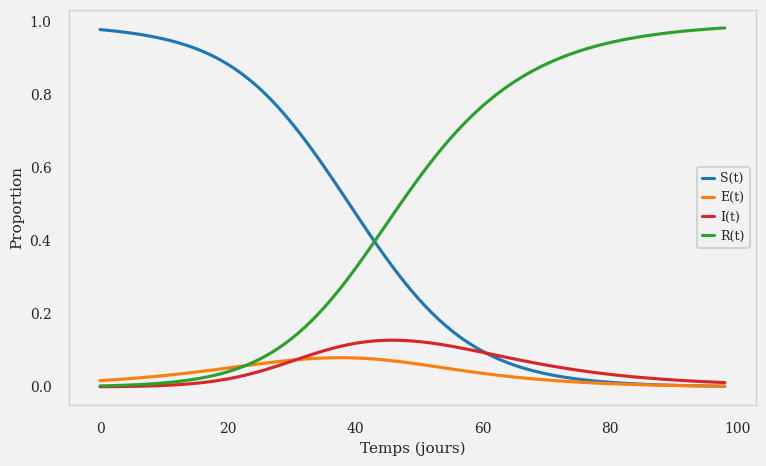

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [246]:
# ‚îÄ‚îÄ‚îÄ 7. Visualisation SEIR sans grille, style coh√©rent ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# Style graphique harmonis√©
sns.set_theme(style="white", context="talk", palette="colorblind")
plt.rcParams["figure.facecolor"] = "#f2f2f2"
plt.rcParams["axes.facecolor"]   = "#f2f2f2"
plt.rcParams["axes.edgecolor"]   = "lightgray"
plt.rcParams["axes.linewidth"]   = 1.0
plt.rc("font",   family="serif", weight="light")
plt.rc("axes",   titlesize=13, labelsize=11)
plt.rc("legend", fontsize=9, handlelength=1, handletextpad=0.5, borderpad=0.4)
plt.rc("xtick",  labelsize=10)
plt.rc("ytick",  labelsize=10)

# Donn√©es
K, Ih, S, E, R, Œ≤, œÉ, Œ≥ = model(t_train)

# Cr√©ation de la figure
fig = plt.figure(figsize=(8,5))  # ‚úÖ d√©finition de fig
plt.plot(df.jour[:idx_split], S.numpy().squeeze(), label="S(t)", color="tab:blue")
plt.plot(df.jour[:idx_split], E.numpy().squeeze(), label="E(t)", color="tab:orange")
plt.plot(df.jour[:idx_split], Ih.numpy().squeeze(), label="I(t)", color="tab:red")
plt.plot(df.jour[:idx_split], R.numpy().squeeze(), label="R(t)", color="tab:green")

# Axes et l√©gende
plt.xlabel("Temps (jours)")
plt.ylabel("Proportion")
plt.legend()
plt.tight_layout()

# ‚úÖ Sauvegarde sans erreur
plt.savefig("SEIR_Maroc.pdf", format="pdf", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

# üì• T√©l√©chargement dans Google Colab
from google.colab import files
files.download("SEIR_Maroc.pdf")


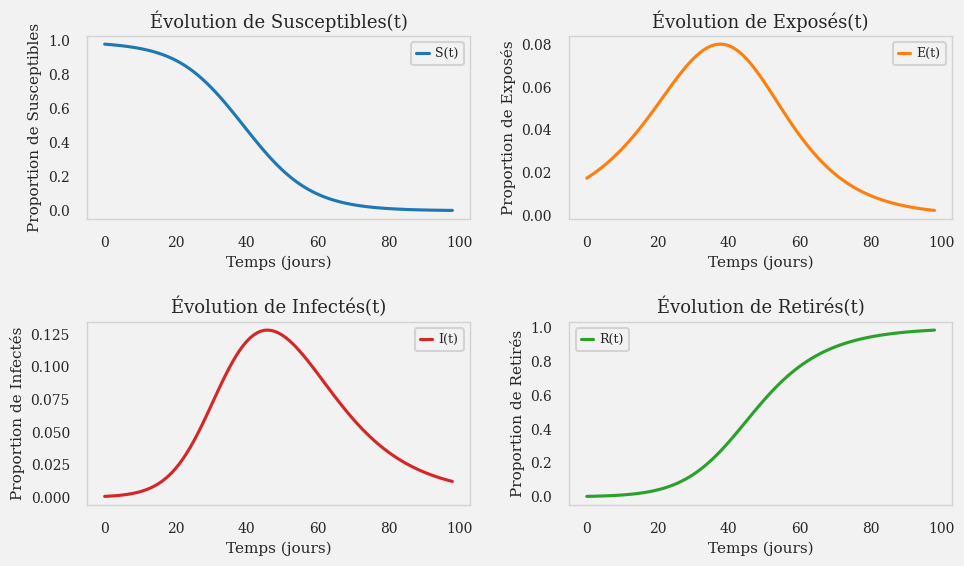

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [261]:
# ‚îÄ‚îÄ‚îÄ Visualisation SEIR ‚Äì 4 sous-graphes avec style harmonis√© ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
from google.colab import files

# üé® Style graphique uniforme
sns.set_theme(style="white", context="talk", palette="colorblind")
plt.rcParams["figure.facecolor"] = "#f2f2f2"
plt.rcParams["axes.facecolor"]   = "#f2f2f2"
plt.rcParams["axes.edgecolor"]   = "lightgray"
plt.rcParams["axes.linewidth"]   = 1.0
plt.rc("font",   family="serif", weight="light")
plt.rc("axes",   titlesize=13, labelsize=11)
plt.rc("legend", fontsize=9, handlelength=1, handletextpad=0.5, borderpad=0.4)
plt.rc("xtick",  labelsize=10)
plt.rc("ytick",  labelsize=10)

# üî¢ Donn√©es depuis le mod√®le
K, Ih, S, E, R, Œ≤, œÉ, Œ≥ = model(t_train)
jours_train = df.jour[:idx_split]

# üìä Figure 2x2
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Sous-graphe S(t)
axs[0, 0].plot(jours_train, S.numpy().squeeze(), color="tab:blue", label="S(t)")
axs[0, 0].set_title("√âvolution de Susceptibles(t)")
axs[0, 0].set_xlabel("Temps (jours)")
axs[0, 0].set_ylabel("Proportion de Susceptibles")
axs[0, 0].legend()

# Sous-graphe E(t)
axs[0, 1].plot(jours_train, E.numpy().squeeze(), color="tab:orange", label="E(t)")
axs[0, 1].set_title("√âvolution de Expos√©s(t)")
axs[0, 1].set_xlabel("Temps (jours)")
axs[0, 1].set_ylabel("Proportion de Expos√©s")
axs[0, 1].legend()

# Sous-graphe I(t)
axs[1, 0].plot(jours_train, Ih.numpy().squeeze(), color="tab:red", label="I(t)")
axs[1, 0].set_title("√âvolution de Infect√©s(t)")
axs[1, 0].set_xlabel("Temps (jours)")
axs[1, 0].set_ylabel("Proportion de Infect√©s")
axs[1, 0].legend()

# Sous-graphe R(t)
axs[1, 1].plot(jours_train, R.numpy().squeeze(), color="tab:green", label="R(t)")
axs[1, 1].set_title("√âvolution de Retir√©s(t)")
axs[1, 1].set_xlabel("Temps (jours)")
axs[1, 1].set_ylabel("Proportion de Retir√©s")
axs[1, 1].legend()

# ‚úÖ Sauvegarde
plt.tight_layout()
plt.savefig("SEIR_Maroc_4plots.pdf", format="pdf", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

# üì• T√©l√©chargement dans Google Colab
files.download("SEIR_Maroc_4plots.pdf")


In [248]:
# üîÑ Pr√©diction des compartiments SEIR pour les donn√©es de train
K, Ih, S, E, R, Œ≤, œÉ, Œ≥ = model(t_train)
data = {
    "Jour": df.jour[:idx_split],
    "S(t)": S.numpy().squeeze(),
    "E(t)": E.numpy().squeeze(),
    "I(t)": Ih.numpy().squeeze(),
    "R(t)": R.numpy().squeeze()
}
df_seir_train = pd.DataFrame(data)
print("\nüìä Tableau des valeurs finales SEIR (Vague Delta - Entra√Ænement)")
print(df_seir_train.tail(10).to_string(index=False))


üìä Tableau des valeurs finales SEIR (Vague Delta - Entra√Ænement)
 Jour     S(t)     E(t)     I(t)     R(t)
   89 0.005154 0.004573 0.020459 0.969815
   90 0.004659 0.004228 0.019297 0.971816
   91 0.004212 0.003908 0.018203 0.973677
   92 0.003810 0.003612 0.017172 0.975406
   93 0.003446 0.003339 0.016202 0.977013
   94 0.003118 0.003085 0.015289 0.978507
   95 0.002822 0.002851 0.014430 0.979897
   96 0.002555 0.002634 0.013621 0.981189
   97 0.002314 0.002434 0.012861 0.982392
   98 0.002096 0.002249 0.012145 0.983510


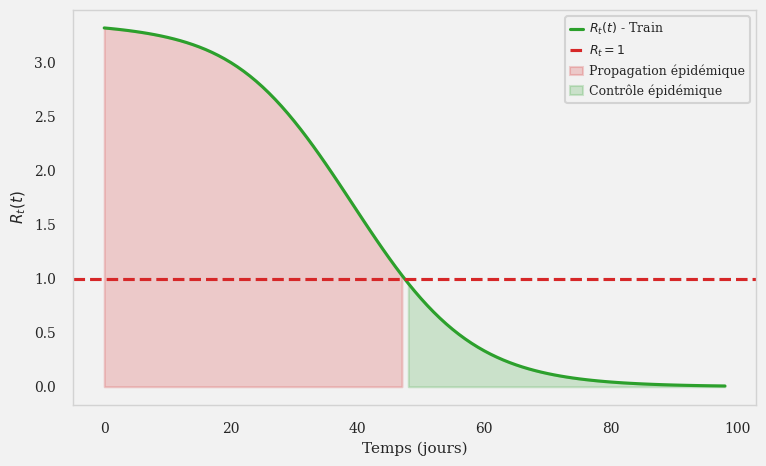

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [262]:
# üîÑ Visualisation de R‚Çú(t) effectif ‚Äì style coh√©rent
_, _, S_train, _, _, beta_v, _, gamma_v = model(t_train)
R0_t_train = (beta_v / gamma_v) * S_train.numpy().squeeze()
jours_train = df.jour[:idx_split]

# üìä Trac√©
fig = plt.figure(figsize=(8, 5))
plt.plot(jours_train, R0_t_train, color="tab:green", label="$R_t(t)$ - Train")
plt.axhline(1, color="tab:red", linestyle="--", label="$R_t = 1$")
plt.fill_between(jours_train, 0, R0_t_train, where=(R0_t_train > 1),
                 color="tab:red", alpha=0.2, label="Propagation √©pid√©mique")
plt.fill_between(jours_train, 0, R0_t_train, where=(R0_t_train <= 1),
                 color="tab:green", alpha=0.2, label="Contr√¥le √©pid√©mique")

plt.xlabel("Temps (jours)")
plt.ylabel("$R_t(t)$")
plt.legend()
plt.tight_layout()

# ‚úÖ Sauvegarde PDF
plt.savefig("Rt_Train.pdf", format="pdf", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

# üì• T√©l√©chargement
from google.colab import files
files.download("Rt_Train.pdf")


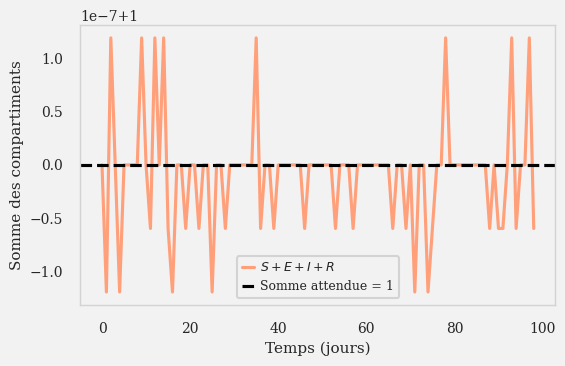

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [263]:
# üîÑ V√©rification conservation S+E+I+R (Train) ‚Äì style coh√©rent avec courbe orange clair

# Donn√©es
K_train, Ih_train, S_train, E_train, R_train, Œ≤_train, œÉ_train, Œ≥_train = model(t_train)
SERI_sum = (S_train + E_train + Ih_train + R_train).numpy().squeeze()

# Trac√©
fig = plt.figure(figsize=(6, 4))
plt.plot(df.jour[:idx_split], SERI_sum, label="$S + E + I + R$", color="lightsalmon")
plt.axhline(1.0, color="black", linestyle="--", label="Somme attendue = 1")

plt.xlabel("Temps (jours)")
plt.ylabel("Somme des compartiments")
plt.legend()
plt.tight_layout()

# Sauvegarde PDF
plt.savefig("SEIR_conservation_lightsalmon.pdf", format="pdf", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

# T√©l√©chargement
from google.colab import files
files.download("SEIR_conservation_lightsalmon.pdf")


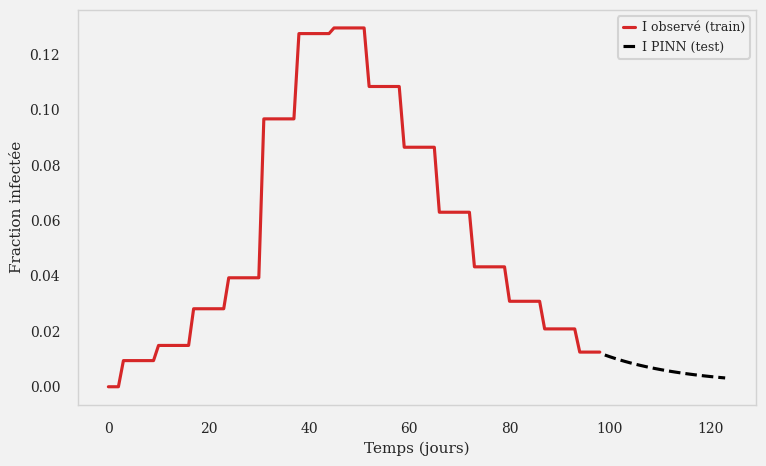

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


üìä Tableau de comparaison (Test) :

 Jour  I R√©el (Test)  I Pr√©dit (PINN)  Erreur Absolue
   99       0.012512         0.011472        0.001040
  100       0.012512         0.010839        0.001673
  101       0.007945         0.010243        0.002298
  102       0.007945         0.009682        0.001738
  103       0.007945         0.009155        0.001210
  104       0.007945         0.008658        0.000714
  105       0.007945         0.008191        0.000247
  106       0.007945         0.007752        0.000193
  107       0.007945         0.007338        0.000607
  108       0.006123         0.006948        0.000825


In [264]:
# üìà Visualisation I(t) ‚Äì Entra√Ænement vs Test (style harmonis√©)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_squared_error
from google.colab import files

# üîß Style graphique harmonis√©
sns.set_theme(style="white", context="talk", palette="colorblind")
plt.rcParams["figure.facecolor"] = "#f2f2f2"
plt.rcParams["axes.facecolor"]   = "#f2f2f2"
plt.rcParams["axes.edgecolor"]   = "lightgray"
plt.rcParams["axes.linewidth"]   = 1.0
plt.rc("font",   family="serif", weight="light")
plt.rc("axes",   titlesize=13, labelsize=11)
plt.rc("legend", fontsize=9, handlelength=1, handletextpad=0.5, borderpad=0.4)
plt.rc("xtick",  labelsize=10)
plt.rc("ytick",  labelsize=10)

# üîé Pr√©diction sur Test
K_test, Ih_test, *_ = model(t_test)
jours      = df.jour.values
jours_test = jours[idx_split:]
mse_test   = mean_squared_error(I_test.squeeze(), Ih_test.numpy().squeeze())

# üìä Trac√©
fig = plt.figure(figsize=(8,5))
plt.plot(jours[:idx_split], I_train.squeeze(), label="I observ√© (train)", color="tab:red")
plt.plot(jours_test, Ih_test.numpy().squeeze(), linestyle="--", label="I PINN (test)", color="black")

plt.xlabel("Temps (jours)")
plt.ylabel("Fraction infect√©e")
plt.legend()
plt.tight_layout()

# ‚úÖ Sauvegarde PDF
plt.savefig("I_test_prediction.pdf", format="pdf", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()
files.download("I_test_prediction.pdf")

# üìÑ Cr√©ation du tableau de comparaison
df_comparaison = pd.DataFrame({
    "Jour": jours_test,
    "I R√©el (Test)": I_test.squeeze(),
    "I Pr√©dit (PINN)": Ih_test.numpy().squeeze(),
    "Erreur Absolue": abs(I_test.squeeze() - Ih_test.numpy().squeeze())
})

print("\nüìä Tableau de comparaison (Test) :\n")
print(df_comparaison.head(10).to_string(index=False))


In [252]:
# ‚îÄ‚îÄ‚îÄ  M√©triques de validation sur le jeu Test ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# üîÑ R√©el vs. pr√©dit sur la zone Test
I_real = I_test.squeeze()
I_pred = Ih_test.numpy().squeeze()
#  Calcul des m√©triques
mae  = mean_absolute_error(I_real, I_pred)
mse  = mean_squared_error(I_real, I_pred)
rmse = np.sqrt(mse)
r2   = r2_score(I_real, I_pred)
print("\nüìä  Validation du mod√®le (jeu Test)")
print(f"   MAE   = {mae:.4e}")
print(f"   MSE   = {mse:.4e}")
print(f"   RMSE  = {rmse:.4e}")
print(f"   R¬≤    = {r2:.4f}")



üìä  Validation du mod√®le (jeu Test)
   MAE   = 7.1401e-04
   MSE   = 8.0449e-07
   RMSE  = 8.9693e-04
   R¬≤    = 0.8487


In [253]:
print(f"\n‚úÖ Param√®tres estim√©s :")
print(f"Œ≤     = {beta:.4f}")
print(f"œÉ     = {sigma:.4f}")
print(f"Œ≥     = {gamma:.4f}")



‚úÖ Param√®tres estim√©s :
Œ≤     = 0.4839
œÉ     = 0.2656
Œ≥     = 0.1426


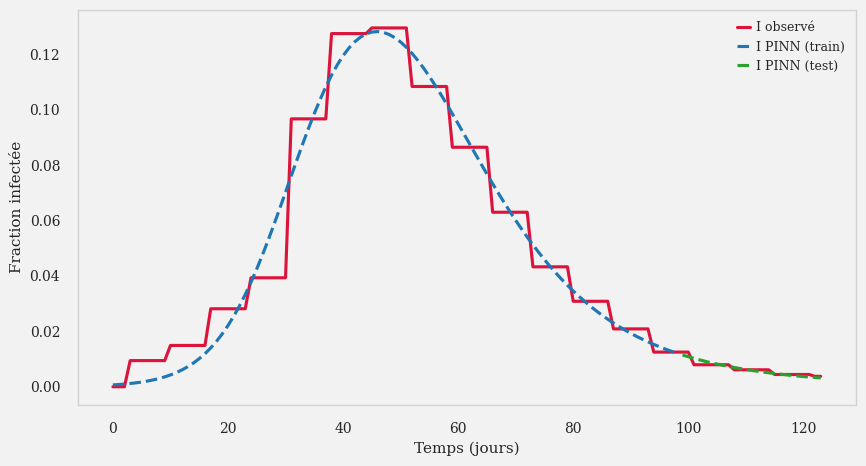

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [265]:
# ‚îÄ‚îÄ‚îÄ Visualisation + t√©l√©chargement du graphique I observ√© vs I PINN ‚îÄ‚îÄ‚îÄ

# Configuration du style graphique
sns.set_theme(style="white", context="talk", palette="colorblind")
plt.rcParams.update({
    "figure.facecolor": "#f2f2f2", "axes.facecolor": "#f2f2f2",
    "axes.edgecolor": "lightgray", "axes.linewidth": 1.0,
    "font.family": "serif", "axes.titlesize": 13, "axes.labelsize": 11,
    "legend.fontsize": 9, "xtick.labelsize": 10, "ytick.labelsize": 10
})

# Cr√©ation du r√©pertoire de sortie
out_dir = pathlib.Path("PINN_outputs"); out_dir.mkdir(exist_ok=True)

# Trac√©
plt.figure(figsize=(9,5))
plt.plot(jours,      np.concatenate([I_train.squeeze(), I_test.squeeze()]), label="I observ√©",   color="crimson")
plt.plot(jours[:idx_split], Ih_train.numpy().squeeze(), "--", label="I PINN (train)", color="tab:blue")
plt.plot(jours_test, Ih_test.numpy().squeeze(),        "--", label="I PINN (test)",  color="tab:green")
plt.xlabel("Temps (jours)")
plt.ylabel("Fraction infect√©e")
plt.legend(frameon=False)
plt.tight_layout()

# Sauvegarde PDF
pdf_path = out_dir / "I_real_vs_PINN.pdf"
plt.savefig(pdf_path, format="pdf", dpi=300, bbox_inches="tight", facecolor=plt.gcf().get_facecolor())
plt.show()

# T√©l√©chargement
files.download(str(pdf_path))


In [255]:
# üîÆ Pr√©diction future des compartiments SEIR (valeurs num√©riques)

# √âtape 1 : G√©n√©rer les temps futurs normalis√©s
T_future = 1.2    # pr√©vision jusqu'√† 20% au-del√† de l'intervalle d'entra√Ænement (si t ‚àà [0,1])
N_future = 50     # nombre de points pr√©dits
t_future = tf.linspace(1.0, T_future, N_future)[:, None]  # shape (N_future, 1)

# √âtape 2 : Appeler le mod√®le sur t_future
Kf, If, Sf, Ef, Rf, _, _, _ = model(t_future)

# √âtape 3 : Organiser les r√©sultats dans un DataFrame
df_future = pd.DataFrame({
    "t_normalis√©": t_future.numpy().squeeze(),
    "S(t)": Sf.numpy().squeeze(),
    "E(t)": Ef.numpy().squeeze(),
    "I(t)": If.numpy().squeeze(),
    "R(t)": Rf.numpy().squeeze()
})

# üîç Affichage des premi√®res lignes
print(df_future.head(10))


   t_normalis√©      S(t)      E(t)      I(t)      R(t)
0     1.000000  0.000195  0.000315  0.003179  0.996311
1     1.004082  0.000186  0.000303  0.003101  0.996410
2     1.008163  0.000178  0.000291  0.003025  0.996506
3     1.012245  0.000170  0.000280  0.002951  0.996599
4     1.016327  0.000162  0.000270  0.002879  0.996690
5     1.020408  0.000155  0.000259  0.002809  0.996777
6     1.024490  0.000148  0.000249  0.002740  0.996862
7     1.028571  0.000142  0.000240  0.002674  0.996944
8     1.032653  0.000135  0.000231  0.002610  0.997024
9     1.036735  0.000129  0.000222  0.002547  0.997102
